# Complex Bayesian Network notebook

#### Import dependencies

In [15]:
# Import dependencies
#%pip install pgmpy==0.1.14
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [16]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Data import and cleaning

#### Import BigPerf data

In [17]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [18]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [19]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [20]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['Low', 'Medium', 'High']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name] = pd.cut(df[column_name], 3, labels=tertile_labels, ordered=True)

    return tert_df

#### Descritise data into catagories

In [21]:
# Discretise BigPerf dataset
cat_df = split_tertiles(df)

cat_df = cat_df.astype('object')

cat_df.head()

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,High,Low,Low,Low,High,Low,Medium,High,Low,High,Low,Low,Low
1,High,Low,Low,Low,High,Low,Low,Low,Low,Low,High,Low,Low
2,High,Low,Low,Low,Medium,Low,Medium,High,Low,High,Low,High,Medium
3,High,Low,Low,Low,Medium,Low,Low,Low,Low,Medium,Low,High,Low
4,High,Low,Low,Low,Medium,Low,High,High,Low,Medium,Low,High,Medium


In [22]:
from pgmpy.estimators import TreeSearch

# learn graph structure
est = TreeSearch(cat_df, root_node="HTT")
dag = est.estimate(estimator_type="tan", class_node="TT")
# nx.draw_circular(
#     dag, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
# )
# plt.show()

Building tree:   0%|          | 0/78.0 [00:00<?, ?it/s]

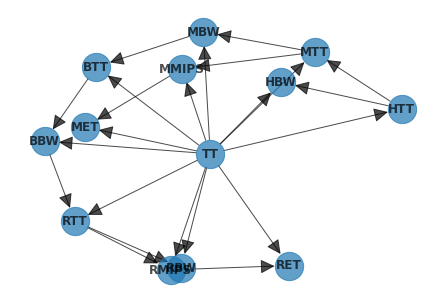

In [23]:
G = nx.DiGraph()
G.add_edges_from(dag.edges)
G.add_nodes_from(dag.nodes)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph

In [24]:
from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel

model = BayesianModel(dag.edges())

model.fit(data=cat_df, estimator=BayesianEstimator)

model.get_cpds()

C:\Python310\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


[<TabularCPD representing P(HTT:2 | TT:3) at 0x2824d4c8670>,
 <TabularCPD representing P(HBW:2 | HTT:2, TT:3) at 0x2824d60f6d0>,
 <TabularCPD representing P(MTT:3 | HTT:2, TT:3) at 0x2824d4c9810>,
 <TabularCPD representing P(MBW:3 | MTT:3, TT:3) at 0x2824d4cb880>,
 <TabularCPD representing P(MMIPS:3 | MTT:3, TT:3) at 0x2824d60f3d0>,
 <TabularCPD representing P(BTT:2 | MBW:3, TT:3) at 0x28213eee020>,
 <TabularCPD representing P(MET:3 | MMIPS:3, TT:3) at 0x2824d60ef50>,
 <TabularCPD representing P(BBW:2 | BTT:2, TT:3) at 0x2824d60f880>,
 <TabularCPD representing P(RTT:3 | BBW:2, TT:3) at 0x2824d4c86a0>,
 <TabularCPD representing P(RMIPS:3 | RTT:3, TT:3) at 0x2824d4c8700>,
 <TabularCPD representing P(RBW:2 | RTT:3, TT:3) at 0x2824d3afa30>,
 <TabularCPD representing P(RET:2 | RMIPS:3, TT:3) at 0x2824d60e4a0>,
 <TabularCPD representing P(TT:3) at 0x2824d60e230>]

In [25]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

f1 = correlation_score(model=model, data=cat_df, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=model, data=cat_df, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=model, data=cat_df, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=model, data=cat_df, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=model, data=cat_df)
ss = structure_score(model=model, data=cat_df, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Strcture score: {ss}')

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Accuracy score: 0.6410256410256411
Precision score: 0.0
Recall score: 0.0
Log-likilihood score: -13990.466871624267
Strcture score: -14371.047446736517


In [26]:
print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of HTT:
+-----------+--------------------+---------------------+--------------------+
| TT        | TT(High)           | TT(Low)             | TT(Medium)         |
+-----------+--------------------+---------------------+--------------------+
| HTT(High) | 0.6003228782287823 | 0.22842835130970726 | 0.4129287598944591 |
+-----------+--------------------+---------------------+--------------------+
| HTT(Low)  | 0.3996771217712177 | 0.7715716486902928  | 0.5870712401055409 |
+-----------+--------------------+---------------------+--------------------+ 

CPT of HBW:
+-----------+-----------------------+-----+----------------------+
| HTT       | HTT(High)             | ... | HTT(Low)             |
+-----------+-----------------------+-----+----------------------+
| TT        | TT(High)              | ... | TT(Medium)           |
+-----------+-----------------------+-----+----------------------+
| HBW(High) | 0.0009604302727621974 | ... | 0.9847803881511747   |
+------